In [37]:
import pandas as pd 
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix,ConfusionMatrixDisplay
import networkx as nx
from node2vec import Node2Vec
from sklearn.model_selection import train_test_split
import umap

In [2]:
def plot_umap_results(embedding, labels=None):
    """
    Affiche le scatter plot UMAP.
    Argument: 
        - embedding: le résultat de fit_transform
        - labels: (optionnel) le tableau des opinions (0, 4, -1)
    """
    if labels is None:
        raise ValueError("La fonction a besoin des labels pour colorer le graph. "
                         "Passez 'train_opinions_np' en deuxième argument.")

    plt.figure(figsize=(12, 8))
    
    categories = {
        0: {'color': '#e74c3c', 'label': 'Sceptique'},
        4: {'color': '#3498db', 'label': 'Pro-climat'},
        -1: {'color': '#bdc3c7', 'label': 'Inconnu'}
    }
    
    for val, info in categories.items():
        mask = (labels == val)
        if np.any(mask):
            plt.scatter(
                embedding[mask, 0], 
                embedding[mask, 1], 
                c=info['color'], 
                label=f"{info['label']} ({val})",
                s=8, 
                alpha=0.7
            )

    plt.title("Répartition des opinions (UMAP)", fontsize=16)
    plt.legend(title="Opinions", markerscale=2)
    plt.show()

In [3]:

fichiers_csv=glob.glob(os.path.join('./sampleGraphs', "graph_*.csv"))

print(f"Trouv� {len(fichiers_csv)} fichiers � fusionner.")
liste_df=[]

for fichier in fichiers_csv:
        print(f"Lecture du fichier {fichier}...")
        df=pd.read_csv(fichier)
        liste_df.append(df)

df_global = pd.concat(liste_df, ignore_index=True)
df_grouped=df.groupby(['user_id', 'original_author'])['nb_retweeted'].sum().reset_index()
df_grouped.to_csv('graphe_complet_groupe.csv', index=False)
print(f"Fusion terminée. Taille finale : {len(df_grouped)} lignes.")
#Creation du graphe :


Trouv� 9 fichiers � fusionner.
Lecture du fichier ./sampleGraphs/graph_2022-01-01_to_2022-01-14.csv...
Lecture du fichier ./sampleGraphs/graph_2022-01-08_to_2022-01-21.csv...
Lecture du fichier ./sampleGraphs/graph_2022-01-15_to_2022-01-28.csv...
Lecture du fichier ./sampleGraphs/graph_2022-01-22_to_2022-02-04.csv...
Lecture du fichier ./sampleGraphs/graph_2022-01-29_to_2022-02-11.csv...
Lecture du fichier ./sampleGraphs/graph_2022-02-05_to_2022-02-18.csv...
Lecture du fichier ./sampleGraphs/graph_2022-02-12_to_2022-02-25.csv...
Lecture du fichier ./sampleGraphs/graph_2022-02-19_to_2022-03-04.csv...
Lecture du fichier ./sampleGraphs/graph_2022-02-26_to_2022-03-11.csv...
Fusion terminée. Taille finale : 53830 lignes.


In [4]:
    
G = nx.from_pandas_edgelist(df_grouped, 
                            source='user_id', 
                            target='original_author', 
                            edge_attr='nb_retweeted')



print(f"Le graphe final contient {G.number_of_nodes()} utilisateurs.")
    
    #Exploration :
node2vec=Node2Vec(G, dimensions=32, walk_length=10, num_walks=10, workers=2)

model=node2vec.fit(window=10, min_count=1, batch_words=4)

nodes =list(G.nodes)
embeddings=[model.wv[str(node)] for node in nodes]

pd_save=pd.DataFrame(embeddings, index=nodes)

pd_save.to_csv("embedings.csv")
embeddings = {str(nodes[i]): embeddings[i] for i in range(len(nodes))}

Le graphe final contient 43168 utilisateurs.


Computing transition probabilities:   0%|          | 0/43168 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [5]:
df_nodes = pd.read_csv('Nodes.csv', dtype={'Id': str})
emb = pd.read_csv('embedings.csv') 

In [6]:
# On force la première colonne des embeddings en texte aussi
emb_col_name = emb.columns[0]
emb[emb_col_name] = emb[emb_col_name].astype(float).apply(lambda x: '{:.0f}'.format(x))

In [7]:
# 2. On crée le dictionnaire avec des clés en TEXTE
mapping_dict = {str(k): v for k, v in zip(df_nodes['Id'], df_nodes['modularity_class'])}

In [8]:
# 3. Filtrage propre
labeled = set(df_nodes['Id'].unique())
emb_labeled = emb[emb[emb_col_name].isin(labeled)].reset_index(drop=True)

In [9]:
y_list = []
liste_emb_filtered = emb_labeled.values.tolist()
train, test = train_test_split(liste_emb_filtered, test_size=0.20, random_state=42)

In [10]:
# On crée des versions sans la colonne ID (qui est à l'indice 0)
train_ = [row[1:] for row in train]
test_ = [row[1:] for row in test]
#apprentissage non supervisé
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    random_state=42
)

# Apprentissage sur la population de 80% avec non supervision
train_embedding = reducer.fit_transform(train_)
test_emb=reducer.transform(test_)
y_list_train = []
for row in train:
    # On transforme l'ID en texte exact, sans virgule ni "e"
    val = '{:.0f}'.format(float(row[0]))
    y_list_train.append(mapping_dict.get(val, -1))

# 3. CRUCIAL : Convertir en tableau NumPy avec un type numérique précis (int64)
train_opinions_np = np.array(y_list_train, dtype=np.int64)

y_list_test = []


for row in test:
    # On transforme l'ID en texte exact, sans virgule ni "e"
    val = '{:.0f}'.format(float(row[0]))
    y_list_test.append(mapping_dict.get(val, -1))

# 3. CRUCIAL : Convertir en tableau NumPy avec un type numérique précis (int64)
test_opinions_np = np.array(y_list_test, dtype=np.int64)

/home/bourenane/.local/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


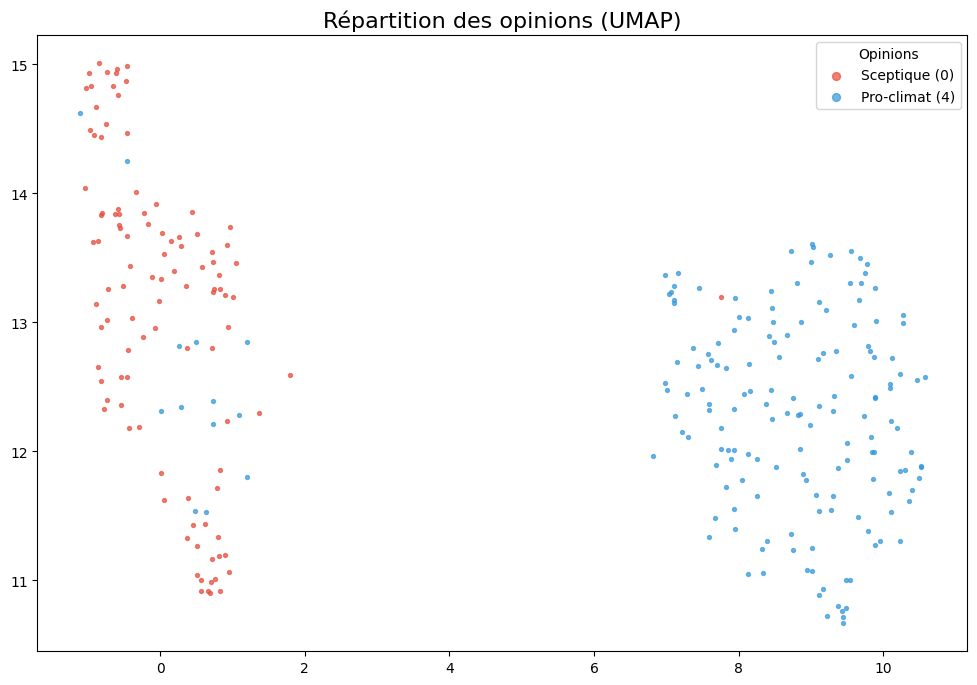

In [11]:
plot_umap_results(train_embedding,train_opinions_np)

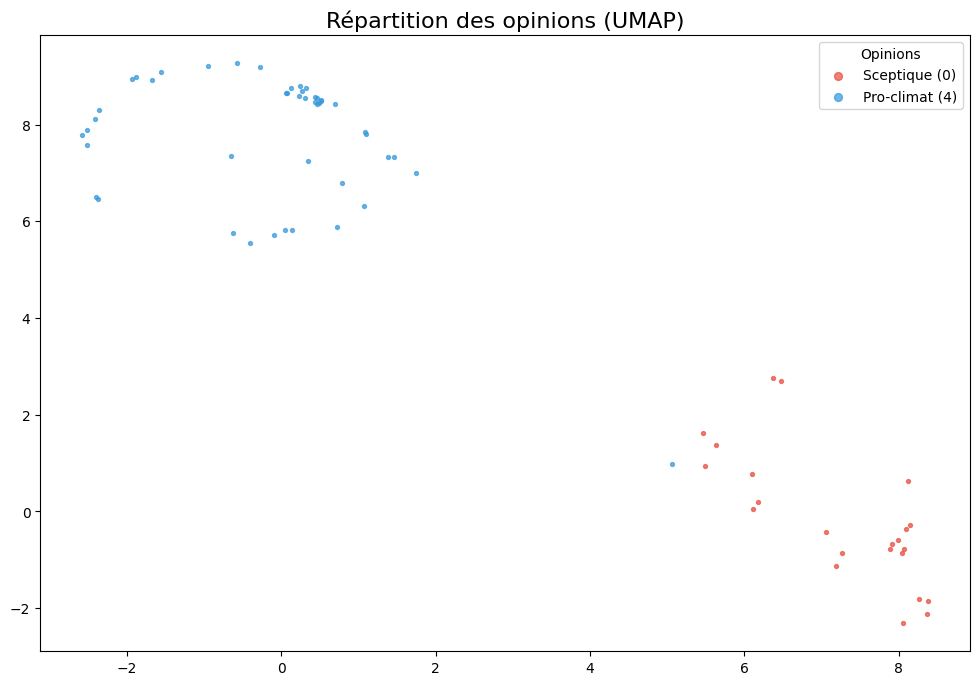

In [10]:
plot_umap_results(test_emb,test_opinions_np)

In [20]:
# Test KNN sur UMAP Non-Supervisé
knn_unsup = KNeighborsClassifier(n_neighbors=5)
knn_unsup.fit(train_embedding, train_opinions_np)
y_pred_unsup = knn_unsup.predict(test_emb)

print("--- RÉSULTATS UMAP SUPERVISÉ ---")
print(f"Accuracy: {accuracy_score(test_opinions_np, y_pred_unsup):.4f}")
print(classification_report(test_opinions_np, y_pred_unsup))

--- RÉSULTATS UMAP SUPERVISÉ ---
Accuracy: 0.9855
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        23
           4       1.00      0.98      0.99        46

    accuracy                           0.99        69
   macro avg       0.98      0.99      0.98        69
weighted avg       0.99      0.99      0.99        69



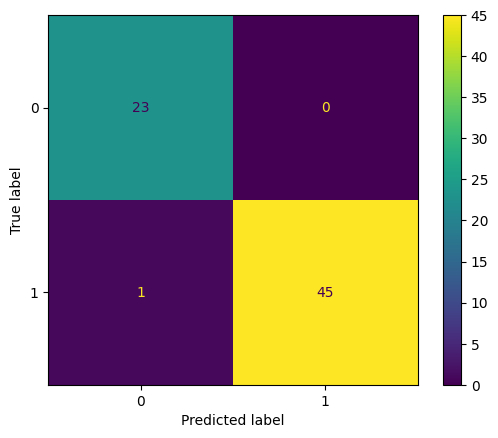

In [38]:

cm=confusion_matrix(test_opinions_np,y_pred_unsup)
d=ConfusionMatrixDisplay(cm)
d.plot()

In [21]:


y_list_train = []
for row in train:
    # On transforme l'ID en texte exact, sans virgule ni "e"
    val = '{:.0f}'.format(float(row[0]))
    y_list_train.append(mapping_dict.get(val, -1))

# 3. CRUCIAL : Convertir en tableau NumPy avec un type numérique précis (int64)
train_opinions_np_tot = np.array(y_list_train, dtype=np.int64)

In [22]:
reducers_tot = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    random_state=42,
    target_weight=0.5  
)
train_embedding_tot = reducers_tot.fit_transform(train_,y=train_opinions_np_tot)
test_emb_tot=reducers_tot.transform(test_)

/home/bourenane/.local/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


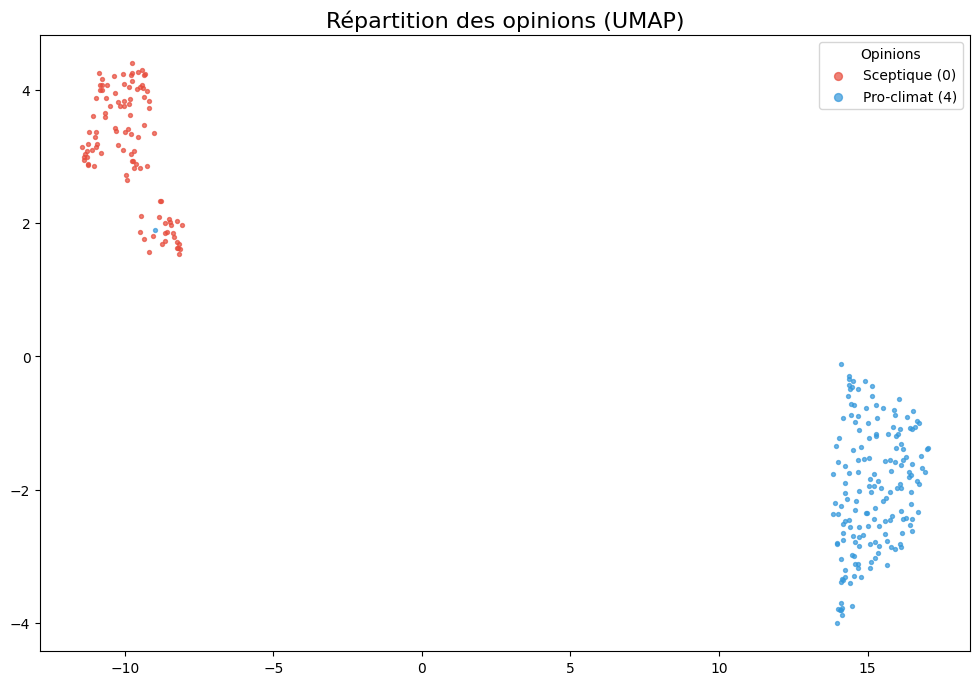

In [23]:
plot_umap_results(train_embedding_tot,train_opinions_np_tot)

In [24]:
y_list_test = []
for row in test:
    # On transforme l'ID en texte exact, sans virgule ni "e"
    val = '{:.0f}'.format(float(row[0]))
    y_list_test.append(mapping_dict.get(val, -1))
                           
test_opinions_np_tot=np.array(y_list_test, dtype=np.int64)

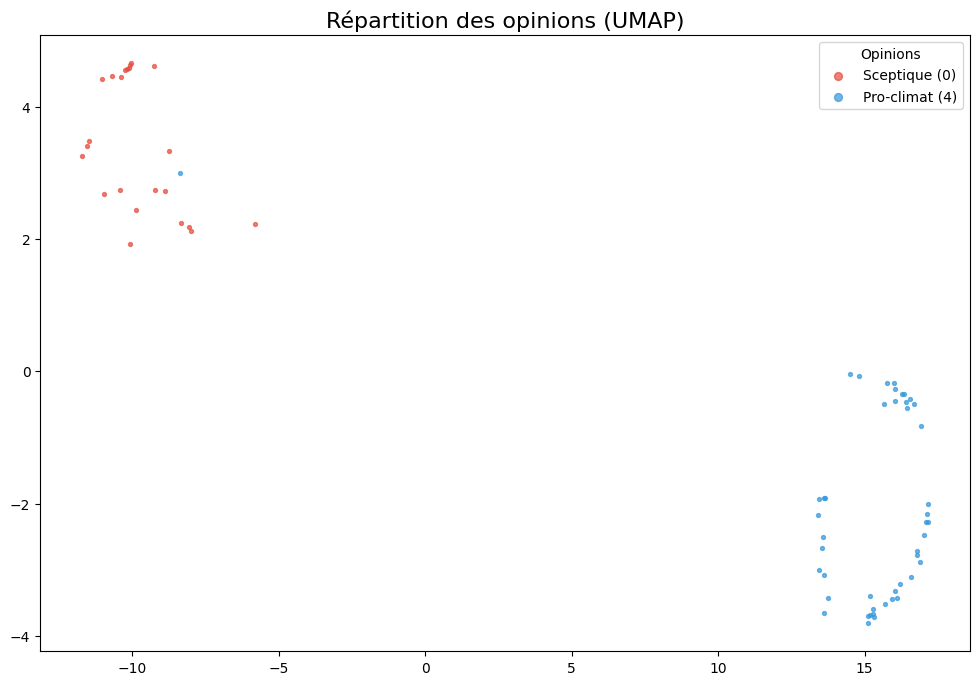

In [25]:
plot_umap_results(test_emb_tot,test_opinions_np_tot)

In [26]:
knn_supper=KNeighborsClassifier(n_neighbors=5)
knn_model=knn_supper.fit(train_embedding_tot,train_opinions_np_tot)
y_pred_sup=knn_model.predict(test_emb_tot)
print(f"Précision sur les personnes connues : {accuracy_score(test_opinions_np_tot, y_pred_sup):.2%}")


Précision sur les personnes connues : 98.55%


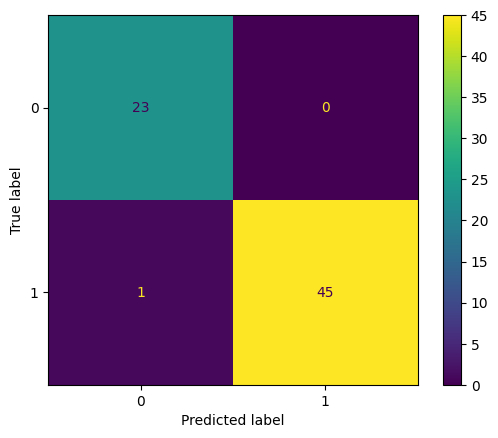

In [39]:
cmSupp=confusion_matrix(test_opinions_np_tot, y_pred_sup)
d2=ConfusionMatrixDisplay(cmSupp)
d2.plot()

In [27]:
#la méthode du barycentre avec changement de coordonnées

In [28]:
mask_scep = (train_opinions_np_tot == 0)
mask_pro = (train_opinions_np_tot == 4)

In [29]:
points_scep = train_embedding_tot[mask_scep]
points_pro = train_embedding_tot[mask_pro]

In [30]:
bary_scep = np.mean(points_scep, axis=0)
bary_pro = np.mean(points_pro, axis=0)

In [31]:
centre_global = (bary_scep + bary_pro) / 2
train_embedding_centre = train_embedding_tot - centre_global

In [32]:
bary_scep_c = bary_scep - centre_global
bary_pro_c = bary_pro - centre_global

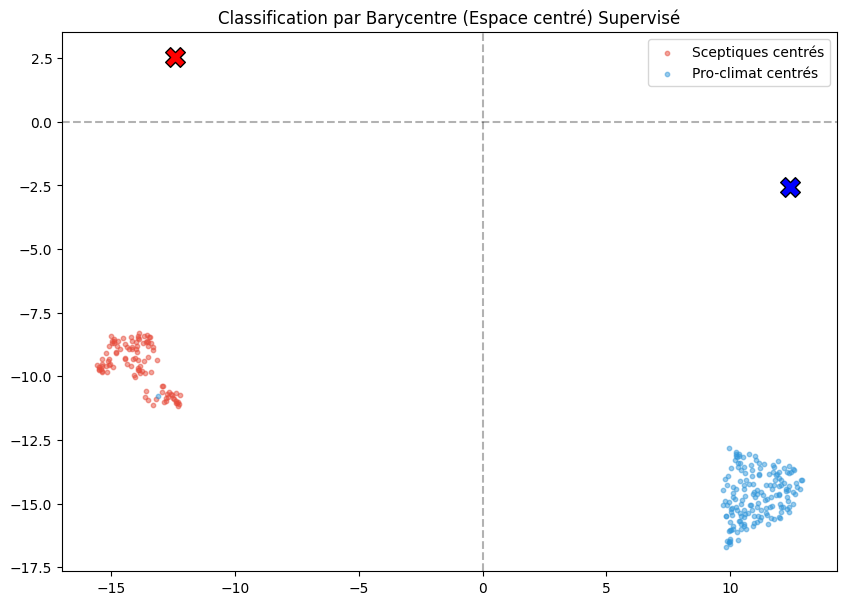

In [71]:
# 4. VISUALISATION
plt.figure(figsize=(10, 7))
plt.scatter(points_scep[:,0] - centre_global[0], points_scep[:,1] - centre_global[1], 
            c='#e74c3c', s=10, alpha=0.5, label='Sceptiques centrés')
plt.scatter(points_pro[:,0] - centre_global[0], points_pro[:,1] - centre_global[1], 
            c='#3498db', s=10, alpha=0.5, label='Pro-climat centrés')

# Affichage des centres
plt.scatter(bary_scep_c[0], bary_scep_c[1], c='red', marker='X', s=200, edgecolors='black')
plt.scatter(bary_pro_c[0], bary_pro_c[1], c='blue', marker='X', s=200, edgecolors='black')

plt.axhline(0, color='black', linestyle='--', alpha=0.3)
plt.axvline(0, color='black', linestyle='--', alpha=0.3)
plt.title("Classification par Barycentre (Espace centré) Supervisé")
plt.legend()
plt.show()

In [34]:
def calculer_distance(p1, p2):

    return np.sqrt(np.sum((p1 - p2)**2))

def predire_classe(point, b_scep, b_pro):
    dist_scep = calculer_distance(point, b_scep)
    dist_pro = calculer_distance(point, b_pro)
    
    # On retourne 0 si plus proche de sceptique, sinon 4
    if dist_scep < dist_pro:
        return 0
    else:
        return 4

In [35]:

predictions = []
for point in test_emb_tot:
    predictions.append(predire_classe(point, bary_scep, bary_pro))

predictions = np.array(predictions)


nb_correct = np.sum(predictions == test_opinions_np_tot)
accuracy_manuelle = nb_correct / len(test_opinions_np_tot)

print(f"Nombre de points bien classés : {nb_correct} sur {len(test_opinions_np_tot)}")
print(f"Précision manuelle : {accuracy_manuelle * 100:.2f}%")

Nombre de points bien classés : 68 sur 69
Précision manuelle : 98.55%


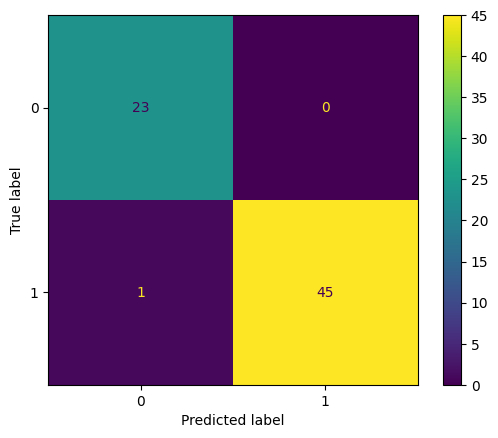

In [40]:
cm=confusion_matrix(test_opinions_np_tot,predictions)
d3=ConfusionMatrixDisplay(cm)
d3.plot()

In [70]:
#Non Supervise

In [63]:
points_scep_Usup = train_embedding[train_opinions_np==0]
points_pro_Usup = train_embedding[train_opinions_np==4]

In [64]:
bary_scepu_Usup = np.mean(points_scep_Usup, axis=0)
bary_pro_Usup = np.mean(points_pro_Usup, axis=0)

In [65]:
centre_global = (bary_scepu_Usup + bary_pro_Usup) / 2
train_embedding_centre_Usup = train_embedding - centre_global

In [66]:
bary_scep_c_Usup = bary_scepu_Usup - centre_global
bary_pro_c_Usup = bary_pro_Usup - centre_global

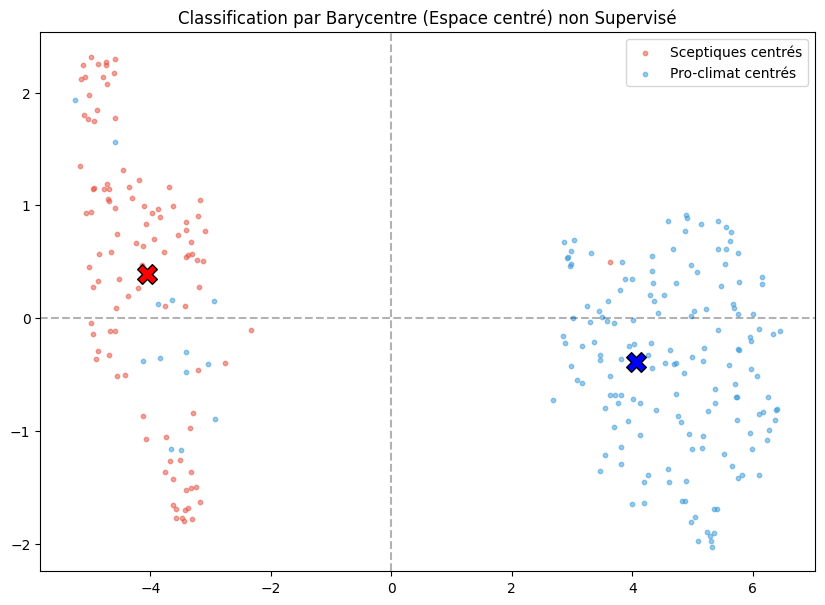

In [67]:
# 4. VISUALISATION
plt.figure(figsize=(10, 7))
plt.scatter(points_scep_Usup[:,0] - centre_global[0], points_scep_Usup[:,1] - centre_global[1], 
            c='#e74c3c', s=10, alpha=0.5, label='Sceptiques centrés')
plt.scatter(points_pro_Usup[:,0] - centre_global[0], points_pro_Usup[:,1] - centre_global[1], 
            c='#3498db', s=10, alpha=0.5, label='Pro-climat centrés')

# Affichage des centres
plt.scatter(bary_scep_c_Usup[0], bary_scep_c_Usup[1], c='red', marker='X', s=200, edgecolors='black')
plt.scatter(bary_pro_c_Usup[0], bary_pro_c_Usup[1], c='blue', marker='X', s=200, edgecolors='black')

plt.axhline(0, color='black', linestyle='--', alpha=0.3)
plt.axvline(0, color='black', linestyle='--', alpha=0.3)
plt.title("Classification par Barycentre (Espace centré) non Supervisé")
plt.legend()
plt.show()

In [68]:
predictions = []
for point in test_emb:
    predictions.append(predire_classe(point, bary_scepu_Usup, bary_pro_Usup))

predictions = np.array(predictions)


nb_correct = np.sum(predictions == test_opinions_np)
accuracy_manuelle = nb_correct / len(test_opinions_np)

print(f"Nombre de points bien classés : {nb_correct} sur {len(test_opinions_np)}")
print(f"Précision manuelle : {accuracy_manuelle * 100:.2f}%")

Nombre de points bien classés : 68 sur 69
Précision manuelle : 98.55%


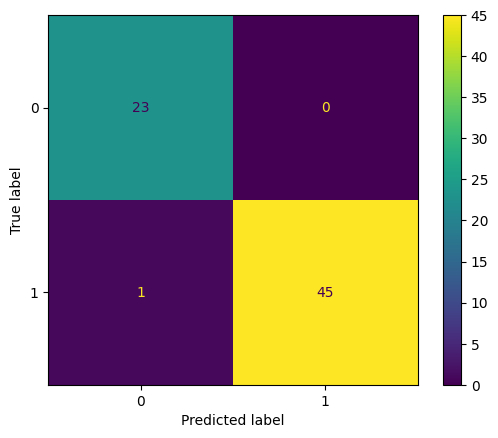

In [69]:
cm=confusion_matrix(test_opinions_np,predictions)
d3=ConfusionMatrixDisplay(cm)
d3.plot()

In [ ]:
# =========================
# GNN (GCN) complet avec réutilisation de TON split train/test
# (train/test déjà calculés à partir de liste_emb_filtered = emb_labeled.values.tolist())
# =========================

import pandas as pd
import torch
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

import matplotlib.pyplot as plt


# -----------------------
# 0) Reproductibilité
# -----------------------
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# -----------------------
# 1) Chargement
# -----------------------
edges_file = "graphe_complet_groupe.csv"
nodes_file = "NODES_climatoscope_graph_2022-07-01_2022-10-30_th=3.0_flc=0_world_2185-pro-anti_Louvaindic_testtop_tableusers.csv"

df_edges = pd.read_csv(edges_file)
df_nodes = pd.read_csv(nodes_file)


# -----------------------
# 2) Nettoyage / alignement
# -----------------------
node_ids_in_edges = set(df_edges["user_id"]).union(set(df_edges["original_author"]))
node_ids_in_nodes = df_nodes["Id"]
common_ids = list(node_ids_in_edges.intersection(node_ids_in_nodes))

df_nodes_filtered = (
    df_nodes[df_nodes["Id"].isin(common_ids)]
    .sort_values("Id")
    .reset_index(drop=True)
)

valid_ids = set(df_nodes_filtered["Id"])
df_edges_filtered = df_edges[
    df_edges["user_id"].isin(valid_ids) &
    df_edges["original_author"].isin(valid_ids)
].copy()

id_to_idx = {id_val: i for i, id_val in enumerate(df_nodes_filtered["Id"])}


# -----------------------
# 3) Features (x)
# -----------------------
feature_cols = ["nb_retweets", "nb_retweeted", "pageranks"]
df_nodes_filtered[feature_cols] = df_nodes_filtered[feature_cols].fillna(0)

x = torch.tensor(df_nodes_filtered[feature_cols].to_numpy(), dtype=torch.float)

# Standardisation
x = (x - x.mean(dim=0)) / (x.std(dim=0) + 1e-8)


# -----------------------
# 4) Labels (y)
# -----------------------
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(df_nodes_filtered["modularity_class"].to_numpy())
y = torch.tensor(y_encoded, dtype=torch.long)

num_classes = len(encoder.classes_)
print("Classes originales :", encoder.classes_)
print("Classes encodées   :", set(y_encoded))


# -----------------------
# 5) Edges (edge_index) + rendre le graphe non orienté
# -----------------------
src = df_edges_filtered["user_id"].map(id_to_idx).to_numpy()
dst = df_edges_filtered["original_author"].map(id_to_idx).to_numpy()

edge_index = torch.tensor([src, dst], dtype=torch.long)

# Ajout des arêtes inverses (undirected)
edge_index_rev = torch.flip(edge_index, dims=[0])
edge_index = torch.cat([edge_index, edge_index_rev], dim=1)

data = Data(x=x, edge_index=edge_index, y=y)


# -----------------------
# 6) Split train/test (réutilise TON split existant)
# IMPORTANT: suppose que tu as déjà fait quelque part AVANT :
#   liste_emb_filtered = emb_labeled.values.tolist()
#   train, test = train_test_split(liste_emb_filtered, test_size=0.20, random_state=42)
#
# Dans cette liste, la 1ère valeur de chaque ligne est l'ID (colonne "Unnamed: 0")
# -----------------------

# Vérification minimale : train/test doivent exister
try:
    _ = train[0]
    _ = test[0]
except NameError as e:
    raise NameError(
        "Les variables 'train' et 'test' n'existent pas. "
        "Tu dois exécuter d'abord :\n"
        "liste_emb_filtered = emb_labeled.values.tolist()\n"
        "train, test = train_test_split(liste_emb_filtered, test_size=0.20, random_state=42)\n"
    ) from e

# IDs extraits depuis les lignes du split (row[0] = ID)
train_ids = set(str(row[0]) for row in train)
test_ids  = set(str(row[0]) for row in test)

# IDs des noeuds (convertis en str pour matcher proprement)
node_ids = df_nodes_filtered["Id"].astype(str)

data.train_mask = torch.tensor(node_ids.isin(train_ids).values, dtype=torch.bool)
data.test_mask  = torch.tensor(node_ids.isin(test_ids).values, dtype=torch.bool)

print("Train nodes:", int(data.train_mask.sum()), "Test nodes:", int(data.test_mask.sum()))


data = data.to(device)


# -----------------------
# 7) Modèle
# -----------------------
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden=16, dropout_p=0.5):
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden)
        self.conv2 = GCNConv(hidden, num_classes)
        self.dropout_p = dropout_p

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


model = GCN(num_features=data.num_features, num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


# -----------------------
# 8) Entraînement + historique (éval "propre": recalcul out en eval)
# -----------------------
train_losses, train_accs, test_accs = [], [], []

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()

    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        out_eval = model(data)  # recalcul sans dropout
        pred = out_eval.argmax(dim=1)

        train_acc = (pred[data.train_mask] == data.y[data.train_mask]).float().mean().item()
        test_acc  = (pred[data.test_mask]  == data.y[data.test_mask]).float().mean().item()

    train_accs.append(train_acc)
    test_accs.append(test_acc)

    if epoch % 100 == 0:
        print(f"Epoch {epoch:04d} | Loss {loss.item():.4f} | Train {train_acc:.3f} | Test {test_acc:.3f}")


# -----------------------
# 9) Plot
# -----------------------
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(train_accs, label="Train")
plt.plot(test_accs, label="Test", linestyle="--")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
print(emb_labeled.columns)
print(emb_labeled.head(2))
